In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

In [10]:
print("=" * 80)
print("PHASE 0: DATA PREPARATION AND PARAMETER ESTIMATION")
print("=" * 80)

price_file = Path.cwd() / 'Basket option data.xlsx'
if not price_file.exists():
    raise FileNotFoundError(f"Could not find price data file: {price_file}")

df_prices_raw = pd.read_excel(price_file, sheet_name='Historical prices', header=None)

nvda_data = pd.DataFrame({
    'Date': pd.to_datetime(df_prices_raw.iloc[2:, 0], errors='coerce'),
    'NVDA_Close': pd.to_numeric(df_prices_raw.iloc[2:, 5], errors='coerce')
}).dropna()

msft_data = pd.DataFrame({
    'Date': pd.to_datetime(df_prices_raw.iloc[2:, 8], errors='coerce'),
    'MSFT_Close': pd.to_numeric(df_prices_raw.iloc[2:, 13], errors='coerce')
}).dropna()

df_clean = pd.merge(nvda_data, msft_data, on='Date', how='inner').sort_values('Date').reset_index(drop=True)

df_clean['r_NVDA'] = np.log(df_clean['NVDA_Close'] / df_clean['NVDA_Close'].shift(1))
df_clean['r_MSFT'] = np.log(df_clean['MSFT_Close'] / df_clean['MSFT_Close'].shift(1))
df_clean = df_clean.dropna()

S0_NVDA = float(df_clean['NVDA_Close'].iloc[-1])
S0_MSFT = float(df_clean['MSFT_Close'].iloc[-1])

SIGMA_NVDA = float(df_clean['r_NVDA'].std() * np.sqrt(252))
SIGMA_MSFT = float(df_clean['r_MSFT'].std() * np.sqrt(252))

CORRELATION = float(df_clean['r_NVDA'].corr(df_clean['r_MSFT']))

# Load external parameters
R_FREE = 0.038  # Risk-free rate (can be adjusted)
Q_NVDA = 0.0002  # Dividend yield for NVDA (0.02%)
Q_MSFT = 0.007  # Dividend yield for MSFT (0.7%)

config = {
    'S0_NVDA': S0_NVDA,
    'S0_MSFT': S0_MSFT,
    'SIGMA_NVDA': SIGMA_NVDA,
    'SIGMA_MSFT': SIGMA_MSFT,
    'CORRELATION': CORRELATION,
    'R_FREE': R_FREE,
    'Q_NVDA': Q_NVDA,
    'Q_MSFT': Q_MSFT,
    'sample_size': len(df_clean)
}

print(f"Spot Price NVDA (S0_NVDA): ${S0_NVDA:.2f}")
print(f"Spot Price MSFT (S0_MSFT): ${S0_MSFT:.2f}")
print(f"Volatility NVDA (SIGMA_NVDA): {SIGMA_NVDA:.4f}")
print(f"Volatility MSFT (SIGMA_MSFT): {SIGMA_MSFT:.4f}")
print(f"Correlation (ρ): {CORRELATION:.4f}")
print(f"Risk-Free Rate (R_FREE): {R_FREE:.4f}")
print(f"Dividend Yield NVDA (Q_NVDA): {Q_NVDA:.4f}")
print(f"Dividend Yield MSFT (Q_MSFT): {Q_MSFT:.4f}")
print(f"Sample Size: {len(df_clean)} days")




PHASE 0: DATA PREPARATION AND PARAMETER ESTIMATION
Spot Price NVDA (S0_NVDA): $177.82
Spot Price MSFT (S0_MSFT): $476.99
Volatility NVDA (SIGMA_NVDA): 0.5008
Volatility MSFT (SIGMA_MSFT): 0.2414
Correlation (ρ): 0.6273
Risk-Free Rate (R_FREE): 0.0380
Dividend Yield NVDA (Q_NVDA): 0.0002
Dividend Yield MSFT (Q_MSFT): 0.0070
Sample Size: 249 days


In [11]:
print("\n" + "=" * 80)
print("PHASE 1: MODEL PARAMETER SETUP")
print("=" * 80)

N = 10000
T = 0.47
ALPHA = 0.25
K_BASKET = 10000000

# Replication strikes
K_P3 = 175.00  # NVDA call strike
K_P4 = 490.00  # MSFT call strike

# Calculate initial allocation (50/50 notional split)
N_NVDA = (0.5 * K_BASKET) / S0_NVDA
N_MSFT = (0.5 * K_BASKET) / S0_MSFT

print(f"Number of Simulations (N): {N:,}")
print(f"Time to Maturity (T): {T:.2f} years")
print(f"Risk Premium Factor (ALPHA): {ALPHA:.2f}")
print(f"Basket Strike (K_BASKET): ${K_BASKET:,}")
print(f"Replication Strike P3 (NVDA): ${K_P3:.2f}")
print(f"Replication Strike P4 (MSFT): ${K_P4:.2f}")
print(f"Number of NVDA Shares (N_NVDA): {N_NVDA:.4f}")
print(f"Number of MSFT Shares (N_MSFT): {N_MSFT:.4f}")


PHASE 1: MODEL PARAMETER SETUP
Number of Simulations (N): 10,000
Time to Maturity (T): 0.47 years
Risk Premium Factor (ALPHA): 0.25
Basket Strike (K_BASKET): $10,000,000
Replication Strike P3 (NVDA): $175.00
Replication Strike P4 (MSFT): $490.00
Number of NVDA Shares (N_NVDA): 28118.3219
Number of MSFT Shares (N_MSFT): 10482.4001


In [12]:
# ============================================================================
# PHASE 2: MONTE CARLO SIMULATION AND ASSET PRICING (PV)
# ============================================================================

print("\n" + "=" * 80)
print("PHASE 2: MONTE CARLO SIMULATION AND ASSET PRICING (PV)")
print("=" * 80)

# Set random seed for reproducibility
np.random.seed(2025)

# Generate N independent standard normal random numbers
E1 = np.random.randn(N)
E2 = np.random.randn(N)

# Apply correlation using Cholesky decomposition
# Correlation matrix
corr_matrix = np.array([[1.0, CORRELATION], [CORRELATION, 1.0]])
L = np.linalg.cholesky(corr_matrix)

# Transform to correlated random variables
Z_correlated = np.column_stack([E1, E2]) @ L.T
Z1_NVDA = Z_correlated[:, 0]
Z2_MSFT = Z_correlated[:, 1]

# BSM path generation with drift term: (R_FREE - Q - 0.5 * SIGMA^2) * T
drift_NVDA = (R_FREE - Q_NVDA - 0.5 * SIGMA_NVDA**2) * T
drift_MSFT = (R_FREE - Q_MSFT - 0.5 * SIGMA_MSFT**2) * T

S_T_NVDA = S0_NVDA * np.exp(drift_NVDA + SIGMA_NVDA * np.sqrt(T) * Z1_NVDA)
S_T_MSFT = S0_MSFT * np.exp(drift_MSFT + SIGMA_MSFT * np.sqrt(T) * Z2_MSFT)

# Calculate basket payoff (Y)
basket_T = N_NVDA * S_T_NVDA + N_MSFT * S_T_MSFT
PAYOFF_BASKET = np.maximum(basket_T - K_BASKET, 0)

# Calculate replication payoffs (P_j,T)
# P1: NVDA stock (terminal value)
P1_T = S_T_NVDA

# P2: MSFT stock (terminal value)
P2_T = S_T_MSFT

# P3: NVDA call option at strike K_P3
P3_T = np.maximum(S_T_NVDA - K_P3, 0)

# P4: MSFT call option at strike K_P4
P4_T = np.maximum(S_T_MSFT - K_P4, 0)

# Calculate discount factor
DF = np.exp(-R_FREE * T)

# Calculate Asset Prices (PV)
Price_P1 = S0_NVDA  # Current spot price of NVDA
Price_P2 = S0_MSFT  # Current spot price of MSFT
Price_P3 = np.mean(P3_T) * DF  # Expected payoff discounted
Price_P4 = np.mean(P4_T) * DF  # Expected payoff discounted
Price_P_Cash = DF  # Cash component

print(f"Discount Factor (DF): {DF:.6f}")
print(f"Price(P1) - NVDA Stock: ${Price_P1:.2f}")
print(f"Price(P2) - MSFT Stock: ${Price_P2:.2f}")
print(f"Price(P3) - NVDA Call K={K_P3}: ${Price_P3:.2f}")
print(f"Price(P4) - MSFT Call K={K_P4}: ${Price_P4:.2f}")
print(f"Price(P_Cash): ${Price_P_Cash:.6f}")



PHASE 2: MONTE CARLO SIMULATION AND ASSET PRICING (PV)
Discount Factor (DF): 0.982299
Price(P1) - NVDA Stock: $177.82
Price(P2) - MSFT Stock: $476.99
Price(P3) - NVDA Call K=175.0: $26.61
Price(P4) - MSFT Call K=490.0: $28.10
Price(P_Cash): $0.982299


In [13]:

# ============================================================================
# PHASE 3: LINEAR REGRESSION TO FIND QUANTITY (W_j)
# ============================================================================

print("\n" + "=" * 80)
print("PHASE 3: LINEAR REGRESSION TO FIND QUANTITY (W_j)")
print("=" * 80)

# Define Y and X
Y = PAYOFF_BASKET  # Target: basket payoff
X = np.column_stack([P1_T, P2_T, P3_T, P4_T])  # Features: replication payoffs

# Run multiple linear regression with intercept
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X, Y)

# Extract quantities
W1 = regression_model.coef_[0]
W2 = regression_model.coef_[1]
W3 = regression_model.coef_[2]
W4 = regression_model.coef_[3]
W0_INTERCEPT = regression_model.intercept_  # Cash quantity

# Calculate residuals
PAYOFF_REPLICATION = regression_model.predict(X)
RESID = PAYOFF_BASKET - PAYOFF_REPLICATION

print(f"W1 (NVDA Stock Quantity): {W1:.6f}")
print(f"W2 (MSFT Stock Quantity): {W2:.6f}")
print(f"W3 (NVDA Call Quantity): {W3:.6f}")
print(f"W4 (MSFT Call Quantity): {W4:.6f}")
print(f"W0 (Cash/Intercept Quantity): {W0_INTERCEPT:.6f}")
print(f"R-squared: {regression_model.score(X, Y):.6f}")



PHASE 3: LINEAR REGRESSION TO FIND QUANTITY (W_j)
W1 (NVDA Stock Quantity): -1015.768615
W2 (MSFT Stock Quantity): 358.632675
W3 (NVDA Call Quantity): 29662.073580
W4 (MSFT Call Quantity): 10291.982810
W0 (Cash/Intercept Quantity): -89310.160212
R-squared: 0.986642


In [14]:

# ============================================================================
# PHASE 4: VALUATION CALCULATION
# ============================================================================

print("\n" + "=" * 80)
print("PHASE 4: VALUATION CALCULATION")
print("=" * 80)

# Calculate asset costs
COST_P1 = W1 * Price_P1
COST_P2 = W2 * Price_P2
COST_P3 = W3 * Price_P3
COST_P4 = W4 * Price_P4
COST_W0 = W0_INTERCEPT * Price_P_Cash

# Calculate valuation
VALUATION = COST_P1 + COST_P2 + COST_P3 + COST_P4 + COST_W0

print(f"COST_P1 (W1 × Price_P1): ${COST_P1:,.2f}")
print(f"COST_P2 (W2 × Price_P2): ${COST_P2:,.2f}")
print(f"COST_P3 (W3 × Price_P3): ${COST_P3:,.2f}")
print(f"COST_P4 (W4 × Price_P4): ${COST_P4:,.2f}")
print(f"COST_W0 (W0 × Price_P_Cash): ${COST_W0:,.2f}")
print(f"VALUATION (Fair Value): ${VALUATION:,.2f}")




PHASE 4: VALUATION CALCULATION
COST_P1 (W1 × Price_P1): $-180,623.98
COST_P2 (W2 × Price_P2): $171,064.20
COST_P3 (W3 × Price_P3): $789,416.83
COST_P4 (W4 × Price_P4): $289,249.48
COST_W0 (W0 × Price_P_Cash): $-87,729.24
VALUATION (Fair Value): $981,377.29


In [15]:
# ============================================================================
# PHASE 5: RISK PREMIUM AND FINAL PRICE
# ============================================================================

print("\n" + "=" * 80)
print("PHASE 5: RISK PREMIUM AND FINAL PRICE")
print("=" * 80)

# Calculate statistics of residuals
RESID_MEAN = np.mean(RESID)
RESID_STD = np.std(RESID)
RESID_MIN = np.min(RESID)
RESID_MAX = np.max(RESID)
RESID_5TH = np.percentile(RESID, 5)
RESID_95TH = np.percentile(RESID, 95)

# Calculate worst case loss (5th percentile of residuals - worst case loss)
# The 5th percentile represents the worst case loss (left tail, negative value)
V_VaR = RESID_5TH  # This is already negative, representing worst case loss

# Calculate risk premium (use absolute value since risk premium should be positive)
RISK_CHANGE = ALPHA * abs(V_VaR)

# Calculate final price
FINAL_PRICE = VALUATION + RISK_CHANGE

print(f"Average of Residuals (Mean): ${RESID_MEAN:,.2f}")
print(f"Standard Deviation of Residuals: ${RESID_STD:,.2f}")
print(f"Minimum Residual: ${RESID_MIN:,.2f}")
print(f"Maximum Residual: ${RESID_MAX:,.2f}")
print(f"5th Percentile of Residuals (V_VaR - Worst Case Loss): ${V_VaR:,.2f}")
print(f"95th Percentile of Residuals: ${RESID_95TH:,.2f}")
print(f"Risk Premium (RISK_CHANGE = ALPHA × |V_VaR|): ${RISK_CHANGE:,.2f}")
print(f"FINAL_PRICE (VALUATION + RISK_CHANGE): ${FINAL_PRICE:,.2f}")

# ============================================================================
# OUTPUT SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("FINAL OUTPUT SUMMARY")
print("=" * 80)
print(f"FINAL_PRICE: ${FINAL_PRICE:,.2f}")
print(f"VALUATION: ${VALUATION:,.2f}")
print(f"RISK_CHANGE: ${RISK_CHANGE:,.2f}")
print(f"\nQuantities:")
print(f"  W0 (Cash): {W0_INTERCEPT:.6f}")
print(f"  W1 (NVDA Stock): {W1:.6f}")
print(f"  W2 (MSFT Stock): {W2:.6f}")
print(f"  W3 (NVDA Call K={K_P3}): {W3:.6f}")
print(f"  W4 (MSFT Call K={K_P4}): {W4:.6f}")




PHASE 5: RISK PREMIUM AND FINAL PRICE
Average of Residuals (Mean): $0.00
Standard Deviation of Residuals: $192,940.40
Minimum Residual: $-1,471,205.25
Maximum Residual: $148,266.81
5th Percentile of Residuals (V_VaR - Worst Case Loss): $-426,336.84
95th Percentile of Residuals: $132,334.28
Risk Premium (RISK_CHANGE = ALPHA × |V_VaR|): $106,584.21
FINAL_PRICE (VALUATION + RISK_CHANGE): $1,087,961.50

FINAL OUTPUT SUMMARY
FINAL_PRICE: $1,087,961.50
VALUATION: $981,377.29
RISK_CHANGE: $106,584.21

Quantities:
  W0 (Cash): -89310.160212
  W1 (NVDA Stock): -1015.768615
  W2 (MSFT Stock): 358.632675
  W3 (NVDA Call K=175.0): 29662.073580
  W4 (MSFT Call K=490.0): 10291.982810



PHASE 6: 3D VISUALIZATION AND BONUS GRAPH
Creating 3D Bubble Scatter Plot...


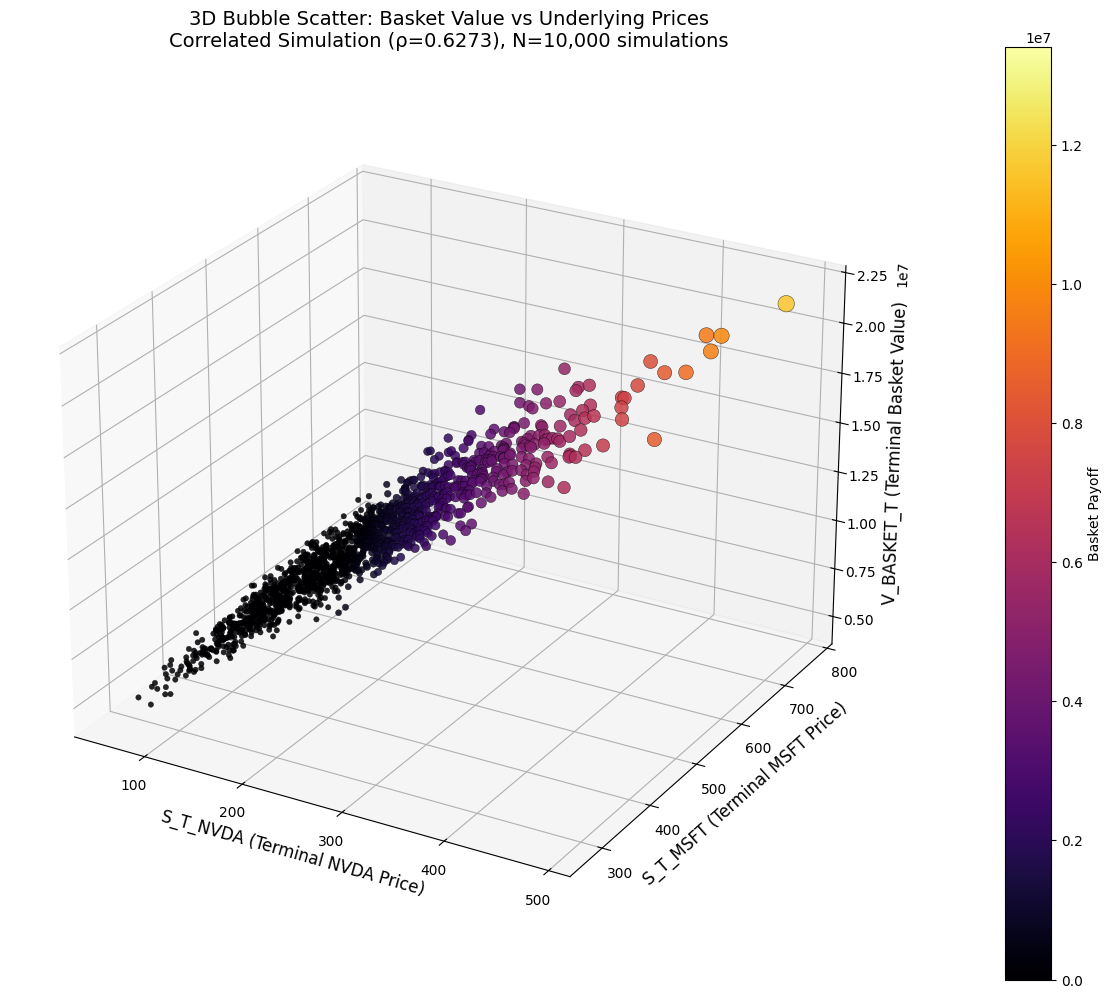

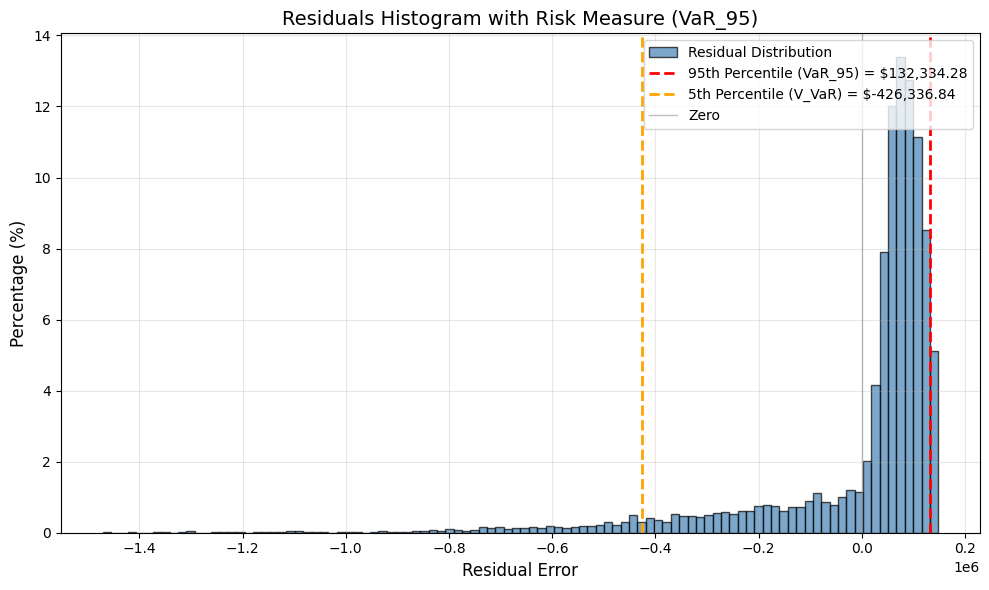


All visualizations displayed inline.

COMPLETE: All phases executed successfully!


In [16]:
# PHASE 6: 3D VISUALIZATION AND BONUS GRAPH

print("\n" + "=" * 80)
print("PHASE 6: 3D VISUALIZATION AND BONUS GRAPH")
print("=" * 80)


# ============================================================================ #
# 3D SCATTER PLOT (Bubble Visualization)
# ============================================================================ #
print("Creating 3D Bubble Scatter Plot...")

fig1 = plt.figure(figsize=(12, 10))
ax1 = fig1.add_subplot(111, projection='3d')

# Sample data for visualization (use subset for clarity)
sample_size = min(1500, N)
indices = np.random.choice(N, sample_size, replace=False)

x_vals = S_T_NVDA[indices]
y_vals = S_T_MSFT[indices]
z_vals = basket_T[indices]
payoff_slice = PAYOFF_BASKET[indices]

# Normalize payoffs for both color mapping and bubble sizing
payoff_norm = Normalize(vmin=PAYOFF_BASKET.min(), vmax=PAYOFF_BASKET.max())
color_map = cm.inferno
bubble_sizes = np.interp(payoff_slice,
                         (PAYOFF_BASKET.min(), PAYOFF_BASKET.max()),
                         (15, 160))

scatter = ax1.scatter(
    x_vals,
    y_vals,
    z_vals,
    c=payoff_slice,
    cmap=color_map,
    norm=payoff_norm,
    s=bubble_sizes,
    alpha=0.85,
    linewidth=0.3,
    edgecolor='black',
    depthshade=False,
)

# Set labels
ax1.set_xlabel('S_T_NVDA (Terminal NVDA Price)', fontsize=12)
ax1.set_ylabel('S_T_MSFT (Terminal MSFT Price)', fontsize=12)
ax1.set_zlabel('V_BASKET_T (Terminal Basket Value)', fontsize=12)

# Set title to reflect correlated simulation result
ax1.set_title(f'3D Bubble Scatter: Basket Value vs Underlying Prices\n'
              f'Correlated Simulation (ρ={CORRELATION:.4f}), N={N:,} simulations',
              fontsize=14, pad=20)

# Add colorbar
scalar_map = cm.ScalarMappable(norm=payoff_norm, cmap=color_map)
scalar_map.set_array([])
cbar1 = fig1.colorbar(scalar_map, ax=ax1, pad=0.1)
cbar1.set_label('Basket Payoff', fontsize=10)

# Improve viewing angle for better separation
ax1.view_init(elev=25, azim=-60)

plt.tight_layout()
plt.show()

# ============================================================================ #
# RESIDUALS HISTOGRAM (BONUS)
# ============================================================================ #

fig2 = plt.figure(figsize=(10, 6))
ax2 = fig2.add_subplot(111)

# Plot histogram with percentage (frequency as percentage)
n, bins, patches = ax2.hist(RESID, bins=100, edgecolor='black', alpha=0.7,
                            color='steelblue', label='Residual Distribution',
                            weights=np.ones_like(RESID) / len(RESID) * 100)

# Calculate 95th percentile (VaR_95)
VaR_95 = RESID_95TH

# Plot vertical line at 95th percentile
ax2.axvline(VaR_95, color='red', linestyle='--', linewidth=2,
            label=f'95th Percentile (VaR_95) = ${VaR_95:,.2f}')

# Also plot 5th percentile for reference
ax2.axvline(RESID_5TH, color='orange', linestyle='--', linewidth=2,
            label=f'5th Percentile (V_VaR) = ${RESID_5TH:,.2f}')

# Add vertical line at zero for reference
ax2.axvline(0, color='gray', linestyle='-', linewidth=1, alpha=0.5, label='Zero')

# Set labels
ax2.set_xlabel('Residual Error', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_title('Residuals Histogram with Risk Measure (VaR_95)', fontsize=14)

# Add legend
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAll visualizations displayed inline.")
print("\n" + "=" * 80)
print("COMPLETE: All phases executed successfully!")
print("=" * 80)